# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input.

## System: driven damped pendulum

Consider a single pendulum with angle $\theta(t)$ and input $u(t)$ evolving according to:

$$ \ddot{\theta} + \frac{\mathcal{g}}{l} \sin(\theta) + \frac{\gamma}{l} \dot{\theta} = \frac{1}{ml} u\, .$$

where $m$ is mass, $l$ is length, $\gamma$ is damping and $\mathcal{g}$ is Earth's gravity.

In [2]:
using Revise
using ForwardDiff
using Optim
using RxInfer
using SpecialFunctions
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3,margin=20Plots.pt)

includet("../NARXAgents.jl"); using .NARXAgents
includet("./Pendulums.jl"); using .Pendulums

In [3]:
# System parameters
sys_mass = 2.0
sys_length = 0.5
sys_damping = 0.05
sys_tqlims = (-5., 5.)
sys_mnoise_sd = 1e-2

0.01

In [48]:
N = 100
Δt = 0.2
tsteps = range(0.0, step=Δt, length=N)

0.0:0.2:19.8

In [49]:
# Inputs
u_lims = (-10., 10.)./Δt
A  = rand(10)*200 .- 100
Ω  = rand(10)*3
controls = clamp.(mean([A[i]*sin.(Ω[i].*tsteps) for i = 1:10]) ./ 5, -10., 10.);

### Test system

In [50]:
init_state = [π/2, 0.0]
pendulum = SPendulum(init_state = init_state, 
                     torque_lims = u_lims,
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     Δt=Δt)

states = zeros(2,N)
observations = zeros(N)
torques = zeros(N)

for k in 1:N
    states[:,k] = pendulum.state
    observations[k] = pendulum.sensor
    step!(pendulum, controls[k])
    torques[k] = pendulum.torque
end

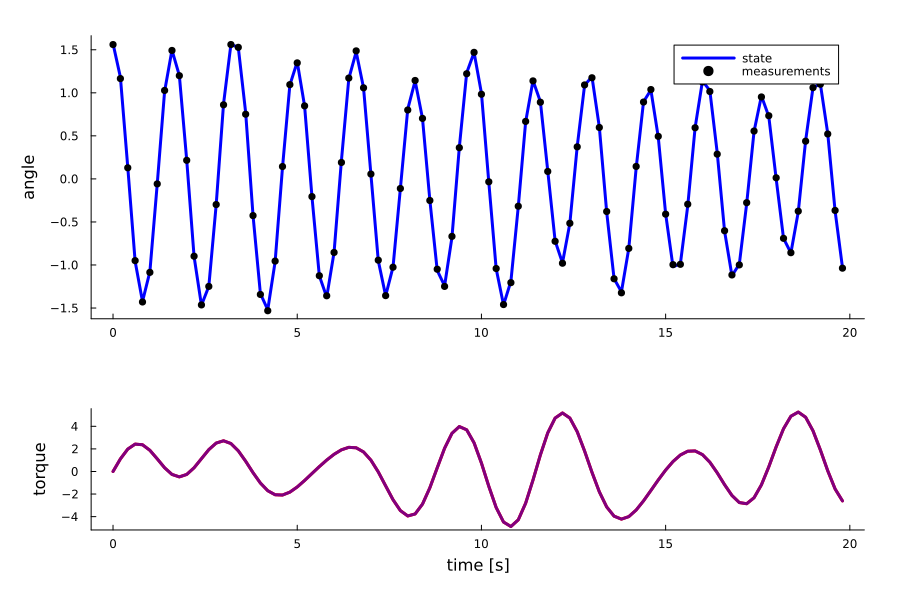

In [51]:
p1 = plot(ylabel="angle")
plot!(tsteps, states[1,:], color="blue", label="state")
scatter!(tsteps, observations, color="black", label="measurements")
p2 = plot(xlabel="time [s]", ylabel="torque")
plot!(tsteps, controls[:], color="red")
plot!(tsteps, torques[:], color="purple")
plot(p1,p2, layout=grid(2,1, heights=[0.7, 0.3]), size=(900,600))

## Parameter estimation

In [67]:
# NARX settings
H = 1
Ly = 2
Lu = 1
M = size(ϕ(zeros(Ly+Lu), degree=H),1);

# Specify prior distributions
pτ0 = GammaShapeRate(1e1, 1e0)
pθ0 = MvNormalMeanCovariance(randn(M)./100, 10diagm(ones(M)))
goal = NormalMeanVariance(3.14, 1e-2)

T = 1
u_prior = 0.0
num_iters = 5

agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  memory_actions=Lu, 
                  memory_senses=Ly, 
                  pol_degree=H,
                  thorizon=T,
                  control_prior=u_prior,
                  num_iters=num_iters)

NARXAgent(FactorGraphModel(), Constraints:
  marginals form:
  messages form:
  factorisation:
    q(θ, τ) = q(θ)q(τ)
Options:
  warn = true
, [Inf], MvNormalMeanCovariance(
μ: [-0.0024961864736325026, -0.01916736555461147, -0.0026436425909099302, 0.0007135837042291087]
Σ: [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 10.0 0.0; 0.0 0.0 0.0 10.0]
)
, GammaShapeRate{Float64}(a=10.0, b=1.0), NormalMeanVariance{Float64}(μ=3.14, v=0.01), 1, 5, 0.0, 1, 2, 1, 4, [0.0, 0.0], [0.0])

In [68]:
py = []
qθ = [pθ0]
qτ = [pτ0]
FE = zeros(num_iters,N)

T = 1
@showprogress for k in 1:(N-T)
    
    # Make predictions
    push!(py, predictions(agent, controls[k:k+T], time_horizon=T))
    
    # Update beliefs
    NARXAgents.update!(agent, observations[k], controls[k])
    push!(qθ, agent.qθ)
    push!(qτ, agent.qτ)
    
    # Evaluate
    FE[:,k] = agent.free_energy
end

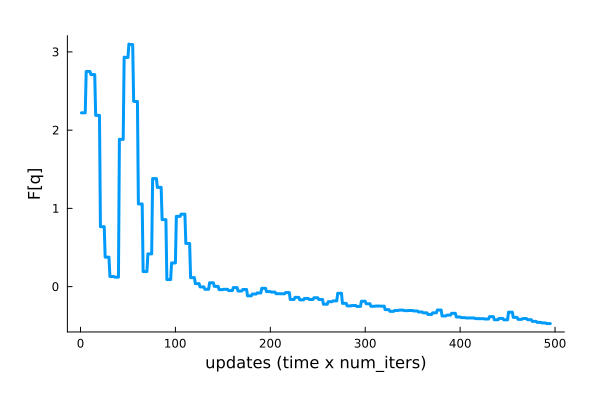

In [69]:
plot(reshape(FE[:,1:(N-T)], (num_iters*(N-T),)), xlabel="updates (time x num_iters)", ylabel="F[q]")

In [70]:
vθ = cat( var.(qθ)...,dims=2)
mθ = cat(mean.(qθ)...,dims=2)

4×100 Matrix{Float64}:
 -0.00249619    1.545         1.54406     …   0.00532244   0.00530439
 -0.0191674    -0.0191674    -0.167161        1.36927      1.36928
 -0.00264364   -0.00264364   -0.00264364     -0.962155    -0.962185
  0.000713584   0.000713584  -0.105018        0.0174759    0.0174807

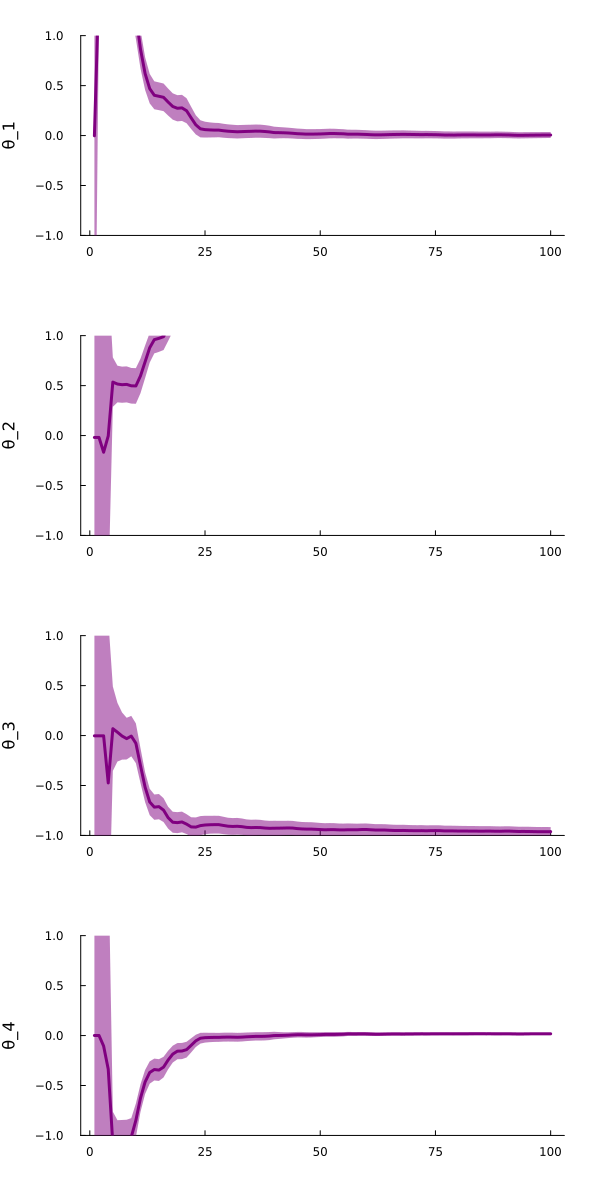

In [71]:
pw = []
for m in 1:M
    pwm = plot(ylims=(-1.,1.))
    plot!(mθ[m,:], ribbon=sqrt.(vθ[m,:]), color="purple", ylabel="θ_$m")
    push!(pw,pwm)
end
plot(pw..., layout=(M,1), size=(600,1200))

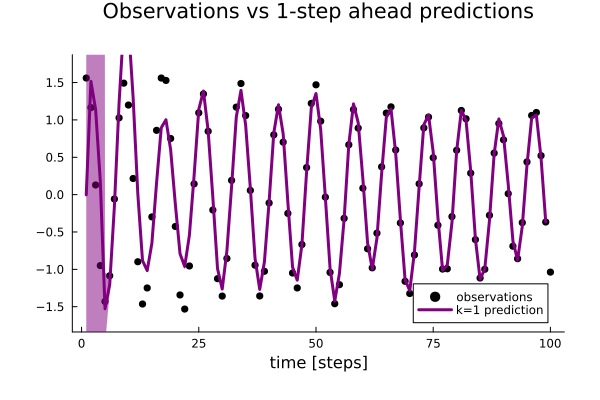

In [74]:
limsb = [minimum(observations)*1.2, maximum(observations)*1.2]
K = 1

p1 = plot(xlabel="time [steps]", title="Observations vs $K-step ahead predictions", ylims=limsb)
scatter!(observations, color="black", label="observations")
plot!([mean(py[k][K]) for k in 1:(N-T)], ribbon=[var(py[k][K]) for k in 1:(N-T)], color="purple", label="k=$K prediction")

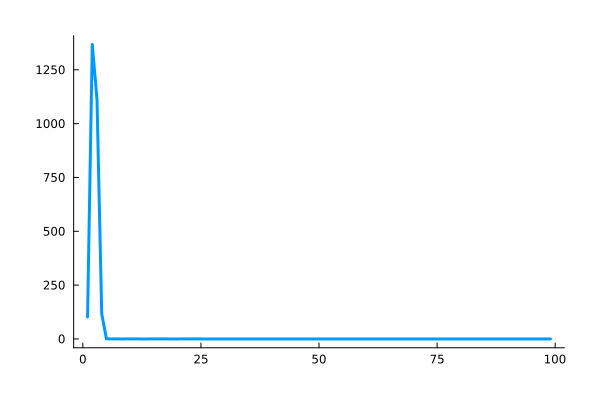

In [73]:
plot([var(py[k][K]) for k in 1:(N-T)])

## Experiments

In [75]:
# Length of trial
N = 50
tsteps = range(0.0, step=Δt, length=N)
T = 10

# Set control properties
goal = NormalMeanVariance(3.14, 1e-3)
control_prior = 0.0
num_iters = 4
u_lims = (-20., 20.)
tlimit = 300

# Polynomial degree
H = 1

# Delay order
Ly = 2
Lu = 1

# Model order
M = size(ϕ(zeros(Ly+Lu), degree=H),1);

# Specify prior distributions
pτ0 = GammaShapeRate(1e2, 1e0)
pθ0 = MvNormalMeanCovariance(randn(M)./100, 10diagm(ones(M)))

init_state = [0.0, 0.0];

### Expected Free Energy minimization

In [94]:
T = 10

goal = NormalMeanVariance(-3.14, 1e-6)
u_lims = (-10.,10.)

pendulum = SPendulum(init_state = [0.0, 0.0], 
                     torque_lims = u_lims,
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     Δt=Δt)

agent = NARXAgent(qθ[end], qτ[end], 
                  goal_prior=goal, 
                  memory_actions=Lu, 
                  memory_senses=Ly, 
                  pol_degree=H,
                  thorizon=T,
                  control_prior=0.0,
                  num_iters=5)

function obj_tmp(agent::NARXAgent, controls)
    "Expected Free Energy"

    μ = mean( agent.qθ)
    Σ = cov(  agent.qθ)
    α = shape(agent.qτ)
    β = rate( agent.qτ)

    ybuffer = agent.ybuffer
    ubuffer = agent.ubuffer
    
    J = 0
    for t in 1:agent.thorizon
        
        # Update control buffer
        ubuffer = NARXAgents.backshift(ubuffer, controls[t])
        ϕ_k = ϕ([ybuffer; ubuffer], degree=agent.pol_degree)
        
        # Prediction
        m_y = dot(μ, ϕ_k)
        v_y = (ϕ_k'*Σ*ϕ_k + 1)*β/α
        # v_y = ϕ_k'*Σ*ϕ_k + β/α

        J += NARXAgents.risk(agent, Normal(m_y,v_y))
        
        # Update previous 
        ybuffer = NARXAgents.backshift(ybuffer, m_y)        
    end
    
    return J
end

opts = Optim.Options(time_limit=60, show_trace=true)

# Objective function
J(u) = obj_tmp(agent, u)

# Constrained minimization procedure
results = optimize(J, -50., 50., zeros(T), Fminbox(LBFGS()), opts, autodiff=:forward)
policy = Optim.minimizer(results)

py = predictions(agent, policy, time_horizon=T)

Fminbox
-------
Initial mu = 2374.28

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 2374.28

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     4.941682e+07     1.754594e+05
 * time: 2.7894973754882812e-5


     1     4.941684e+07     1.805388e+05
 * time: 0.0029959678649902344


     2     4.618090e+07     1.164427e+05
 * time: 0.0035309791564941406


     3     4.473659e+07     1.563158e+05
 * time: 0.004051923751831055


     4     4.442056e+07     1.530195e+05
 * time: 0.004550933837890625


     5     4.419402e+07     1.502717e+05
 * time: 0.004939079284667969


     6     4.409702e+07     1.452355e+05
 * time: 0.005383014678955078


     7     4.395660e+07     1.405806e+05
 * time: 0.006025075912475586


     8     4.371348e+07     1.446390e+05
 * time: 0.007194042205810547


     9     4.367425e+07     1.244665e+05
 * time: 0.0075070858001708984


    10     4.345964e+07     1.073135e+05
 * time: 0.00780797004699707


    11     4.340721e+07     1.020773e+05
 * time: 0.00822305679321289


    12     3.968129e+07     4.066509e+06
 * time: 0.009273052215576172


    13     2.858179e+07     1.760520e+05
 * time: 0.01040506362915039


    14     2.381500e+07     1.332069e+05
 * time: 0.010988950729370117


    15     2.360936e+07     2.747250e+05
 * time: 0.011420965194702148


    16     2.358460e+07     3.452160e+06
 * time: 0.011672019958496094


    17     2.172720e+07     8.821450e+05
 * time: 0.012351036071777344


    18     2.167357e+07     9.108748e+05
 * time: 0.013109922409057617


    19     2.131925e+07     7.265981e+05
 * time: 0.013777971267700195


    20     2.073994e+07     6.562586e+05
 * time: 0.014478921890258789


    21     2.069819e+07     6.558316e+05
 * time: 0.015115022659301758


    22     2.066174e+07     6.535081e+05
 * time: 0.015731096267700195


    23     1.946892e+07     7.595398e+06
 * time: 0.016644954681396484


    24     1.861087e+07     5.648366e+05
 * time: 0.017568111419677734


    25     1.860404e+07     5.611433e+05
 * time: 0.018229007720947266


    26     1.852319e+07     5.408331e+05
 * time: 0.01906895637512207


    27     1.849332e+07     4.169784e+05
 * time: 0.019675016403198242


    28     1.848849e+07     3.982043e+05
 * time: 0.019928932189941406


    29     1.848439e+07     3.555533e+05
 * time: 0.02010798454284668


    30     1.847995e+07     2.799689e+05
 * time: 0.020328044891357422


    31     1.847436e+07     1.541757e+05
 * time: 0.020587921142578125


    32     1.847151e+07     1.421435e+05
 * time: 0.02078104019165039


    33     1.846275e+07     6.459352e+04
 * time: 0.02114105224609375


    34     1.846089e+07     6.409831e+04
 * time: 0.021446943283081055


    35     1.845771e+07     6.135598e+04
 * time: 0.021719932556152344


    36     1.845258e+07     7.645011e+04
 * time: 0.021975040435791016


    37     1.843819e+07     7.755819e+05
 * time: 0.02228689193725586


    38     1.843158e+07     5.672269e+05
 * time: 0.02255105972290039


    39     1.841562e+07     1.625529e+06
 * time: 0.022967100143432617


    40     1.838809e+07     1.102583e+06
 * time: 0.023302078247070312


    41     1.838752e+07     1.280958e+06
 * time: 0.023586034774780273


    42     1.832890e+07     1.116414e+07
 * time: 0.024110078811645508


    43     1.737352e+07     7.433230e+04
 * time: 0.024506092071533203


    44     1.711949e+07     8.866270e+04
 * time: 0.02514505386352539


    45     1.679046e+07     9.790495e+04
 * time: 0.025608062744140625


    46     1.608907e+07     8.956549e+04
 * time: 0.025928974151611328


    47     1.563009e+07     8.722518e+04
 * time: 0.02645397186279297


    48     1.538234e+07     4.463590e+05
 * time: 0.026738882064819336


    49     1.523222e+07     1.500523e+05
 * time: 0.02716994285583496


    50     1.514990e+07     1.145451e+05
 * time: 0.027529001235961914


    51     1.508603e+07     8.690370e+04
 * time: 0.02788090705871582


    52     1.503720e+07     1.146776e+05
 * time: 0.028311967849731445


    53     1.496892e+07     4.320071e+05
 * time: 0.028736114501953125


    54     1.496678e+07     5.580730e+05
 * time: 0.029289960861206055


    55     1.496020e+07     3.578411e+05
 * time: 0.0296781063079834


    56     1.491494e+07     4.776728e+05
 * time: 0.03023695945739746


    57     1.490898e+07     1.900004e+05
 * time: 0.030581951141357422


    58     1.489612e+07     1.381800e+06
 * time: 0.030972003936767578


    59     1.485580e+07     2.125811e+05
 * time: 0.03136897087097168


    60     1.484116e+07     1.293306e+05
 * time: 0.03165793418884277


    61     1.483860e+07     1.284740e+05
 * time: 0.03200387954711914


    62     1.483266e+07     1.417645e+05
 * time: 0.03235006332397461


    63     1.483195e+07     1.283830e+05
 * time: 0.03269195556640625


    64     1.483147e+07     1.277122e+05
 * time: 0.03311896324157715


    65     1.483093e+07     1.064890e+05
 * time: 0.03351187705993652


    66     1.482931e+07     1.144135e+05
 * time: 0.03391695022583008


    67     1.482709e+07     1.206209e+05
 * time: 0.03432488441467285


    68     1.482564e+07     1.355582e+05
 * time: 0.03472399711608887


    69     1.482522e+07     1.088644e+05
 * time: 0.034995079040527344


    70     1.482470e+07     8.767946e+04
 * time: 0.035253047943115234


    71     1.482457e+07     8.483451e+04
 * time: 0.03556108474731445


    72     1.482429e+07     4.731718e+04
 * time: 0.035787105560302734


    73     1.482413e+07     1.948518e+04
 * time: 0.03603696823120117


    74     1.482409e+07     1.845984e+04
 * time: 0.0364689826965332


    75     1.482402e+07     1.042952e+04
 * time: 0.036932945251464844


    76     1.482402e+07     9.761123e+03
 * time: 0.03749489784240723


    77     1.482397e+07     5.155829e+03
 * time: 0.03798103332519531


    78     1.482397e+07     5.300544e+03
 * time: 0.03850698471069336


    79     1.482397e+07     4.851475e+03
 * time: 0.039047956466674805


    80     1.482397e+07     4.115686e+03
 * time: 0.03957796096801758


    81     1.482396e+07     2.899856e+03
 * time: 0.04010891914367676


    82     1.482396e+07     2.338282e+03
 * time: 0.04065299034118652


    83     1.482396e+07     1.013380e+03
 * time: 0.041088104248046875


    84     1.482396e+07     2.562278e+02
 * time: 0.04151105880737305


    85     1.482396e+07     1.358485e+02
 * time: 0.04211997985839844


    86     1.482396e+07     6.941527e+01
 * time: 0.04272890090942383


    87     1.482396e+07     7.302195e+01
 * time: 0.04333996772766113


    88     1.482396e+07     1.647853e+01
 * time: 0.043884992599487305


    89     1.482396e+07     1.825159e+01
 * time: 0.0443720817565918


    90     1.482396e+07     2.162883e+01
 * time: 0.04489898681640625


    91     1.482396e+07     1.376618e+01
 * time: 0.045445919036865234


    92     1.482396e+07     9.068954e-01
 * time: 0.0459749698638916


    93     1.482396e+07     1.179914e+00
 * time: 0.04632210731506348


    94     1.482396e+07     1.205731e-03
 * time: 0.04661893844604492


    95     1.482396e+07     1.393660e-03
 * time: 0.04690289497375488


    96     1.482396e+07     9.835045e-04
 * time: 0.047206878662109375


    97     1.482396e+07     1.712919e-04
 * time: 0.04751992225646973


    98     1.482396e+07     4.180780e-06
 * time: 0.047799110412597656


    99     1.482396e+07     6.224727e-07
 * time: 0.04818892478942871


   100     1.482396e+07     7.332128e-07
 * time: 0.0485379695892334


   101     1.482396e+07     7.600465e-07
 * time: 0.048933982849121094


   102     1.482396e+07     1.689477e-08
 * time: 0.0492401123046875


   103     1.482396e+07     1.146691e-08
 * time: 0.04951596260070801



Exiting inner optimizer with x = [-49.940606736012874, -38.6017885153839, -5.556207387207966, -49.897002635983036, -49.95844722242096, -49.972491749631246, -49.97570811408958, -49.97255914661368, -49.95866135399685, -49.89789324837309]
Current distance to box: 0.0242919
Decreasing barrier term μ.

Fminbox iteration 2
-------------------
Calling inner optimizer with mu = 2.37428

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.488780e+07     9.765216e+04
 * time: 1.2159347534179688e-5


     1     1.486899e+07     3.552075e+04
 * time: 0.0004839897155761719


     2     1.486899e+07     2.142655e+05
 * time: 0.0010161399841308594


     3     1.486899e+07     8.187482e+04
 * time: 0.001377105712890625


     4     1.486899e+07     1.304685e+05
 * time: 0.0016951560974121094


     5     1.486896e+07     1.112728e+05
 * time: 0.0022270679473876953


     6     1.486896e+07     9.704338e+04
 * time: 0.0026290416717529297


     7     1.486896e+07     6.619255e+04
 * time: 0.0029921531677246094


     8     1.486896e+07     1.881744e+04
 * time: 0.0033800601959228516


     9     1.486896e+07     5.140701e+03
 * time: 0.0038089752197265625


    10     1.486896e+07     1.709285e+03
 * time: 0.0042650699615478516


    11     1.486896e+07     5.471653e+02
 * time: 0.004821062088012695


    12     1.486896e+07     5.429749e+01
 * time: 0.0053060054779052734


    13     1.486896e+07     5.453540e+01
 * time: 0.005613088607788086


    14     1.486896e+07     5.201961e+01
 * time: 0.005912065505981445


    15     1.486896e+07     4.901483e+01
 * time: 0.006181955337524414


    16     1.486896e+07     9.837283e-01
 * time: 0.006452083587646484


    17     1.486896e+07     1.664800e-01
 * time: 0.006807088851928711


    18     1.486896e+07     1.819517e-03
 * time: 0.007302999496459961


    19     1.486896e+07     2.876879e-04
 * time: 0.007868051528930664


    20     1.486896e+07     1.147209e-05
 * time: 0.00837397575378418


    21     1.486896e+07     1.085906e-05
 * time: 0.009022951126098633


    22     1.486896e+07     1.085989e-05
 * time: 0.009881973266601562


    23     1.486896e+07     8.629204e-05
 * time: 0.010663986206054688


    24     1.486896e+07     8.629266e-05
 * time: 0.011220932006835938


    25     1.486896e+07     5.463489e-05
 * time: 0.011739015579223633


    26     1.486896e+07     2.609192e-05
 * time: 0.012354135513305664


    27     1.486896e+07     1.993767e-05
 * time: 0.01300501823425293


    28     1.486896e+07     1.993823e-05
 * time: 0.013643980026245117


    29     1.486896e+07     1.993823e-05
 * time: 0.014646053314208984


    30     1.486896e+07     1.993831e-05
 * time: 0.015228033065795898


    31     1.486896e+07     1.086055e-05
 * time: 0.015745162963867188


    32     1.486896e+07     1.085986e-05
 * time: 0.01659703254699707


    33     1.486896e+07     1.085915e-05
 * time: 0.017290115356445312


    34     1.486896e+07     1.085844e-05
 * time: 0.018290042877197266


    35     1.486896e+07     1.085855e-05
 * time: 0.018674135208129883


    36     1.486896e+07     2.609289e-05
 * time: 0.01946401596069336


    37     1.486896e+07     2.609289e-05
 * time: 0.019814014434814453


    38     1.486896e+07     1.147296e-05
 * time: 0.02013397216796875


    39     1.486896e+07     1.147317e-05
 * time: 0.021261930465698242


    40     1.486896e+07     1.085800e-05
 * time: 0.021799087524414062


    41     1.486896e+07     1.085881e-05
 * time: 0.022357940673828125


    42     1.486896e+07     1.993890e-05
 * time: 0.022729158401489258


    43     1.486896e+07     1.993886e-05
 * time: 0.02296614646911621


    44     1.486896e+07     1.147149e-05
 * time: 0.023227930068969727


    45     1.486896e+07     1.147205e-05
 * time: 0.02349710464477539


    46     1.486896e+07     1.147210e-05
 * time: 0.023813962936401367


    47     1.486896e+07     1.147210e-05
 * time: 0.024120092391967773


    48     1.486896e+07     1.147215e-05
 * time: 0.024508953094482422


    49     1.486896e+07     1.147221e-05
 * time: 0.05344510078430176


    50     1.486896e+07     1.085899e-05
 * time: 0.053894996643066406


    51     1.486896e+07     1.085912e-05
 * time: 0.054121971130371094


    52     1.486896e+07     1.085894e-05
 * time: 0.0543210506439209


    53     1.486896e+07     1.085893e-05
 * time: 0.05452895164489746


    54     1.486896e+07     1.085890e-05
 * time: 0.05472707748413086


    55     1.486896e+07     1.973679e-04
 * time: 0.055010080337524414


    56     1.486896e+07     1.230809e-04
 * time: 0.055207014083862305


    57     1.486896e+07     5.611150e-05
 * time: 0.05539512634277344


    58     1.486896e+07     3.380055e-05
 * time: 0.05562114715576172


    59     1.486896e+07     3.379995e-05
 * time: 0.05584216117858887


    60     1.486896e+07     1.993727e-05
 * time: 0.05604410171508789


    61     1.486896e+07     1.085897e-05
 * time: 0.05626416206359863


    62     1.486896e+07     1.085894e-05
 * time: 0.05648493766784668


    63     1.486896e+07     1.085881e-05
 * time: 0.05675816535949707


    64     1.486896e+07     1.085877e-05
 * time: 0.05698895454406738


    65     1.486896e+07     1.085857e-05
 * time: 0.05719494819641113


    66     1.486896e+07     1.085864e-05
 * time: 0.05740213394165039


    67     1.486896e+07     1.085691e-05
 * time: 0.05764293670654297


    68     1.486896e+07     1.085724e-05
 * time: 0.057839155197143555


    69     1.486896e+07     1.147378e-05
 * time: 0.05821108818054199


    70     1.486896e+07     1.147370e-05
 * time: 0.059149980545043945


    71     1.486896e+07     2.609308e-05
 * time: 0.05967903137207031


    72     1.486896e+07     2.609308e-05
 * time: 0.06023406982421875


    73     1.486896e+07     2.609304e-05
 * time: 0.061615943908691406


    74     1.486896e+07     2.609307e-05
 * time: 0.06592607498168945


    75     1.486896e+07     2.609307e-05
 * time: 0.06905603408813477


    76     1.486896e+07     2.609304e-05
 * time: 0.07239103317260742



Exiting inner optimizer with x = [-49.99994018841617, -38.74039018385795, -5.42173396904032, -49.99989735495389, -49.99995851931528, -49.99997250169603, -49.99997569042361, -49.99997251427272, -49.999958558861564, -49.99989751432575]
Current distance to box: 2.43096e-5
Decreasing barrier term μ.

Fminbox iteration 3
-------------------
Calling inner optimizer with mu = 0.00237428

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.486889e+07     9.766873e+04
 * time: 3.0994415283203125e-5


     1     1.486888e+07     2.008721e+03
 * time: 0.0021529197692871094


     2     1.486888e+07     3.323029e+02
 * time: 0.002683877944946289


     3     1.486888e+07     6.078601e+01
 * time: 0.0030939579010009766


     4     1.486888e+07     1.136432e+02
 * time: 0.003484010696411133


     5     1.486888e+07     4.104205e+00
 * time: 0.0038628578186035156


     6     1.486888e+07     8.601918e-03
 * time: 0.004235029220581055


     7     1.486888e+07     8.601996e-03
 * time: 0.004753828048706055



Exiting inner optimizer with x = [-49.99999994018799, -38.74052982092797, -5.421598908631458, -49.999999897355316, -49.99999995851939, -49.999999972501705, -49.99999997569041, -49.999999972514225, -49.99999995855876, -49.99999989751394]
Current distance to box: 2.43096e-8
Decreasing barrier term μ.

Fminbox iteration 4
-------------------
Calling inner optimizer with mu = 2.37428e-6

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.486888e+07     9.766862e+04
 * time: 1.6927719116210938e-5


     1     1.486888e+07     2.142366e+03
 * time: 0.0019588470458984375


     2     1.486888e+07     9.534705e+02
 * time: 0.002485990524291992


     3     1.486888e+07     2.485503e+02
 * time: 0.0029449462890625


     4     1.486888e+07     2.485503e+02
 * time: 0.0033800601959228516


     5     1.486888e+07     7.743462e+00
 * time: 0.0037789344787597656


     6     1.486888e+07     7.743461e+00
 * time: 0.004425048828125


     7     1.486888e+07     7.743460e+00
 * time: 0.005600929260253906


     8     1.486888e+07     2.080019e+01
 * time: 0.006376028060913086


     9     1.486888e+07     7.743461e+00
 * time: 0.006975889205932617


    10     1.486888e+07     7.743461e+00
 * time: 0.007643938064575195


    11     1.486888e+07     7.743461e+00
 * time: 0.00830698013305664


    12     1.486888e+07     1.610607e+01
 * time: 0.009238958358764648


    13     1.486888e+07     1.610607e+01
 * time: 0.009742021560668945


    14     1.486888e+07     2.080019e+01
 * time: 0.010418891906738281


    15     1.486888e+07     2.080019e+01
 * time: 0.010812044143676758


    16     1.486888e+07     2.080019e+01
 * time: 0.011178016662597656


    17     1.486888e+07     2.080019e+01
 * time: 0.011574029922485352


    18     1.486888e+07     2.080019e+01
 * time: 0.011959075927734375


    19     1.486888e+07     1.100913e+01
 * time: 0.012327909469604492


    20     1.486888e+07     2.139595e+01
 * time: 0.012842893600463867


    21     1.486888e+07     2.139595e+01
 * time: 0.01323390007019043


    22     1.486888e+07     2.139595e+01
 * time: 0.013597965240478516


    23     1.486888e+07     8.599370e+00
 * time: 0.013988971710205078



Exiting inner optimizer with x = [-49.999999999940194, -38.740529959719716, -5.421598773281295, -49.99999999989736, -49.999999999958526, -49.9999999999725, -49.99999999997569, -49.999999999972516, -49.99999999995856, -49.99999999989752]
Current distance to box: 2.43077e-11
Decreasing barrier term μ.

Fminbox iteration 5
-------------------
Calling inner optimizer with mu = 2.37428e-9

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.486888e+07     9.766862e+04
 * time: 1.3113021850585938e-5


     1     1.486888e+07     1.371499e+04
 * time: 0.0034770965576171875


     2     1.486888e+07     1.371499e+04
 * time: 0.004060029983520508


     3     1.486888e+07     1.371499e+04
 * time: 0.004748106002807617


     4     1.486888e+07     1.371499e+04
 * time: 0.005125999450683594


     5     1.486888e+07     1.371499e+04
 * time: 0.0055310726165771484


     6     1.486888e+07     1.413091e+04
 * time: 0.006232023239135742


     7     1.486888e+07     1.413091e+04
 * time: 0.0066530704498291016


     8     1.486888e+07     1.413091e+04
 * time: 0.007863044738769531


     9     1.486888e+07     1.371499e+04
 * time: 0.008275032043457031


    10     1.486888e+07     1.371499e+04
 * time: 0.00879216194152832


    11     1.486888e+07     2.504064e+04
 * time: 0.009756088256835938


    12     1.486888e+07     1.413091e+04
 * time: 0.010229110717773438


    13     1.486888e+07     1.413091e+04
 * time: 0.010632038116455078


    14     1.486888e+07     1.413091e+04
 * time: 0.011021137237548828


    15     1.486888e+07     1.371499e+04
 * time: 0.011416196823120117


    16     1.486888e+07     1.371499e+04
 * time: 0.011811017990112305


    17     1.486888e+07     1.371499e+04
 * time: 0.012418985366821289


    18     1.486888e+07     1.413091e+04
 * time: 0.012941122055053711


    19     1.486888e+07     1.413091e+04
 * time: 0.01351618766784668


    20     1.486888e+07     1.413091e+04
 * time: 0.013908147811889648


    21     1.486888e+07     1.413091e+04
 * time: 0.014302968978881836


    22     1.486888e+07     1.413091e+04
 * time: 0.01512002944946289


    23     1.486888e+07     1.413091e+04
 * time: 0.015539169311523438


    24     1.486888e+07     1.371499e+04
 * time: 0.01662302017211914


    25     1.486888e+07     1.371499e+04
 * time: 0.01731109619140625


    26     1.486888e+07     1.371499e+04
 * time: 0.017976045608520508


    27     1.486888e+07     1.371499e+04
 * time: 0.01845717430114746


    28     1.486888e+07     1.371499e+04
 * time: 0.018920183181762695



Exiting inner optimizer with x = [-49.99999999999993, -38.74053009134746, -5.421598591247873, -49.99999999999989, -49.999999999999964, -49.99999999999997, -49.99999999999998, -49.99999999999997, -49.999999999999964, -49.99999999999989]
Current distance to box: 2.13163e-14
Decreasing barrier term μ.

Fminbox iteration 6
-------------------
Calling inner optimizer with mu = 2.37428e-12

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.486888e+07     9.766862e+04
 * time: 1.4066696166992188e-5


     1     1.486888e+07     9.733447e+04
 * time: 0.009272098541259766


     2     1.486888e+07     9.733447e+04
 * time: 0.017822980880737305


     3     1.486888e+07     9.733447e+04
 * time: 0.027491092681884766


     4     1.486888e+07     9.733447e+04
 * time: 0.03676295280456543


     5     1.486888e+07     9.733447e+04
 * time: 0.06353998184204102


     6     1.486888e+07     9.733447e+04
 * time: 0.06993699073791504


     7     1.486888e+07     9.733447e+04
 * time: 0.0770120620727539


     8     1.486888e+07     9.733447e+04
 * time: 0.08173203468322754


     9     1.486888e+07     9.733447e+04
 * time: 0.09109711647033691


    10     1.486888e+07     9.733447e+04
 * time: 0.098297119140625


    11     1.486888e+07     9.733447e+04
 * time: 0.10492992401123047


    12     1.486888e+07     9.733447e+04
 * time: 0.11163592338562012


    13     1.486888e+07     9.733447e+04
 * time: 0.1226339340209961


    14     1.486888e+07     9.733447e+04
 * time: 0.12838006019592285


    15     1.486888e+07     9.733447e+04
 * time: 0.15369296073913574


    16     1.486888e+07     9.733447e+04
 * time: 0.15996909141540527


    17     1.486888e+07     9.733447e+04
 * time: 0.16414809226989746


    18     1.486888e+07     9.733447e+04
 * time: 0.1704399585723877


    19     1.486888e+07     9.733447e+04
 * time: 0.1768949031829834


    20     1.486888e+07     9.733447e+04
 * time: 0.18038296699523926


    21     1.486888e+07     9.733447e+04
 * time: 0.18589305877685547


    22     1.486888e+07     9.733447e+04
 * time: 0.19310998916625977


    23     1.486888e+07     9.733447e+04
 * time: 0.19747591018676758


    24     1.486888e+07     9.733447e+04
 * time: 0.20217204093933105


    25     1.486888e+07     9.733447e+04
 * time: 0.20972704887390137


    26     1.486888e+07     9.733447e+04
 * time: 0.22999191284179688


    27     1.486888e+07     9.733447e+04
 * time: 0.23344898223876953


    28     1.486888e+07     9.733447e+04
 * time: 0.2365560531616211


    29     1.486888e+07     9.733447e+04
 * time: 0.24111104011535645


    30     1.486888e+07     9.733447e+04
 * time: 0.24493002891540527


    31     1.486888e+07     9.733447e+04
 * time: 0.25001001358032227


    32     1.486888e+07     9.733447e+04
 * time: 0.2580749988555908



Exiting inner optimizer with x = [-49.99999999999999, -38.74053008537516, -5.421598701005565, -49.99999999999999, -49.99999999999999, -49.99999999999999, -49.99999999999999, -49.99999999999999, -49.99999999999999, -49.99999999999999]
Current distance to box: 7.10543e-15
Decreasing barrier term μ.

Fminbox iteration 7
-------------------
Calling inner optimizer with mu = 2.37428e-15

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.486888e+07     9.766862e+04
 * time: 1.2874603271484375e-5


     1     1.486888e+07     9.766828e+04
 * time: 0.005891084671020508


     2     1.486888e+07     9.766828e+04
 * time: 0.012300968170166016


     3     1.486888e+07     9.766828e+04
 * time: 0.016987085342407227


     4     1.486888e+07     9.766828e+04
 * time: 0.021799087524414062



Exiting inner optimizer with x = [-49.99999999999999, -38.74053010549188, -5.421598686103598, -49.99999999999999, -49.99999999999999, -49.99999999999999, -49.99999999999999, -49.99999999999999, -49.99999999999999, -49.99999999999999]
Current distance to box: 7.10543e-15
Decreasing barrier term μ.

Fminbox iteration 8
-------------------
Calling inner optimizer with mu = 2.37428e-18

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.486888e+07     9.766862e+04
 * time: 9.059906005859375e-6


     1     1.486888e+07     9.766862e+04
 * time: 0.007292985916137695


     2     1.486888e+07     9.766862e+04
 * time: 0.02682805061340332



Exiting inner optimizer with x = [-49.99999999999999, -38.74053010586156, -5.421598686376864, -49.99999999999999, -49.99999999999999, -49.99999999999999, -49.99999999999999, -49.99999999999999, -49.99999999999999, -49.99999999999999]
Current distance to box: 7.10543e-15
Decreasing barrier term μ.



10-element Vector{Normal{Float64}}:
 Normal{Float64}(μ=-0.8687283370175628, σ=0.3934204262752963)
 Normal{Float64}(μ=-1.8614408782479899, σ=0.25979897173451894)
 Normal{Float64}(μ=-1.8024315189470486, σ=0.0671312140856144)
 Normal{Float64}(μ=-1.5457172241983053, σ=0.39330871855799654)
 Normal{Float64}(μ=-1.2509804925231292, σ=0.3935121687027239)
 Normal{Float64}(μ=-1.094409038783645, σ=0.3932300689546912)
 Normal{Float64}(μ=-1.1636096597781662, σ=0.3926505510880371)
 Normal{Float64}(μ=-1.4090156799083071, σ=0.3921301683123474)
 Normal{Float64}(μ=-1.6784622949901005, σ=0.3919655434896818)
 Normal{Float64}(μ=-1.811285062656334, σ=0.3922327353153525)

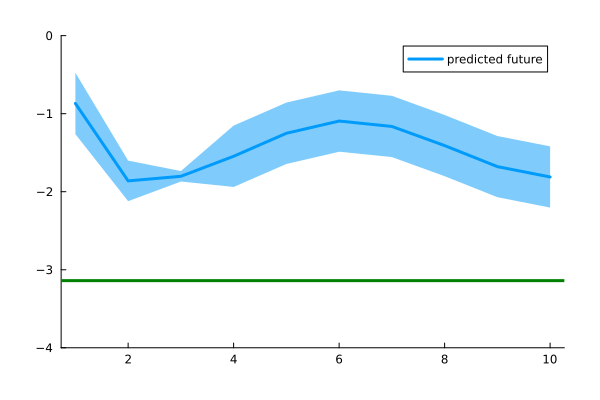

In [95]:
plot(mean.(py), ribbon=sqrt.(var.(py)), label="predicted future", ylims=[-4., 0.])
hline!([mean(goal)], color="green")

In [96]:
policy

10-element Vector{Float64}:
 -49.99999999999999
 -38.74053010586156
  -5.421598686376864
 -49.99999999999999
 -49.99999999999999
 -49.99999999999999
 -49.99999999999999
 -49.99999999999999
 -49.99999999999999
 -49.99999999999999

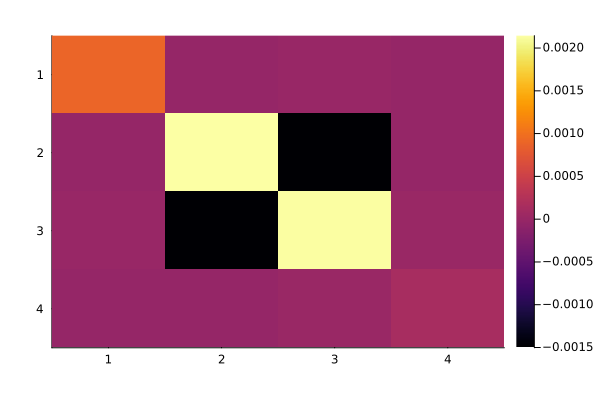

In [97]:
heatmap(cov(qθ[end]), yflip=true)

In [112]:
# Start system
pendulum = SPendulum(init_state = init_state, 
                     torque_lims = u_lims,
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     Δt=Δt)

# Track beliefs
py_EFE = []
pτ_EFE = [pτ0]
pθ_EFE = [pθ0]

# Start agent
agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  memory_actions=Lu, 
                  memory_senses=Ly, 
                  pol_degree=H,
                  thorizon=T,
                  control_prior=control_prior,
                  num_iters=num_iters)

# Preallocate
y_EFE = zeros(N)
u_EFE = zeros(N+1)
FE_EFE = zeros(num_iters, N)
policy = zeros(T)

@showprogress for k in 1:N
    
    # Act upon environment
    step!(pendulum, u_EFE[k])
    y_EFE[k] = pendulum.sensor
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_EFE[k], u_EFE[k])
    
    FE_EFE[:,k] = agent.free_energy
    push!(pθ_EFE, agent.qθ)
    push!(pτ_EFE, agent.qτ)
    
    # Optimal control
    policy = minimizeEFE(agent, u_0=policy, time_limit=tlimit, control_lims=u_lims)
    # policy = minimizeEFE(agent, time_limit=tlimit, control_lims=u_lims)
    u_EFE[k+1] = policy[1]
    
    # Store future predictions
    push!(py_EFE, predictions(agent, policy, time_horizon=T))
    
end

Progress:  12%|████▉                                    |  ETA: 0:00:01

Progress:  20%|████████▎                                |  ETA: 0:00:46

Progress:  26%|██████████▋                              |  ETA: 0:02:43

Progress:  28%|███████████▌                             |  ETA: 0:02:28

Progress:  30%|████████████▎                            |  ETA: 0:02:15

Progress:  32%|█████████████▏                           |  ETA: 0:02:37

Progress:  34%|██████████████                           |  ETA: 0:03:36

Progress:  36%|██████████████▊                          |  ETA: 0:04:10

Progress:  38%|███████████████▋                         |  ETA: 0:04:34

Progress:  40%|████████████████▍                        |  ETA: 0:05:03

Progress:  42%|█████████████████▎                       |  ETA: 0:05:24

Progress:  44%|██████████████████                       |  ETA: 0:05:41

Progress:  46%|██████████████████▉                      |  ETA: 0:05:53

Progress:  48%|███████████████████▋                     |  ETA: 0:05:53

Progress:  50%|████████████████████▌                    |  ETA: 0:05:51

Progress:  52%|█████████████████████▍                   |  ETA: 0:05:32

Progress:  54%|██████████████████████▏                  |  ETA: 0:05:07

Progress:  72%|█████████████████████████████▌           |  ETA: 0:02:20

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:15

Progress: 100%|█████████████████████████████████████████| Time: 0:06:00


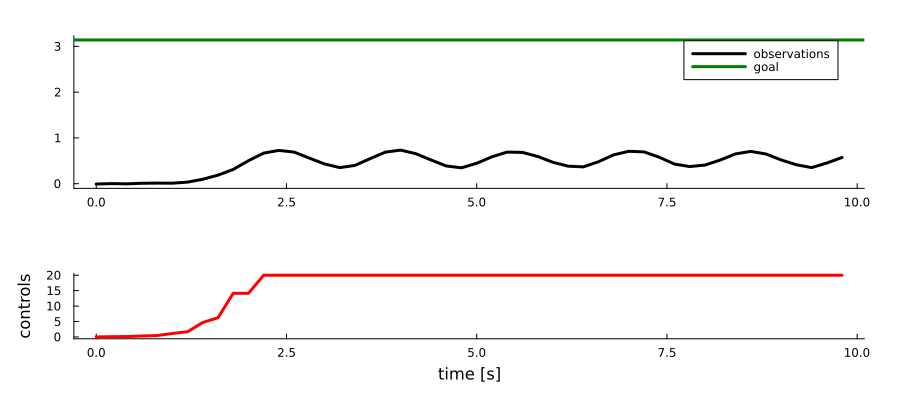

In [20]:
p1 = plot(tsteps, y_EFE, color="black", label="observations")
hline!([mean(goal)], color="green", label="goal")
p4 = plot(tsteps, u_EFE[1:end-1], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [10]:
savefig("figures/NARX-EFE-1Pendulum-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-EFE-1Pendulum-trial.png"

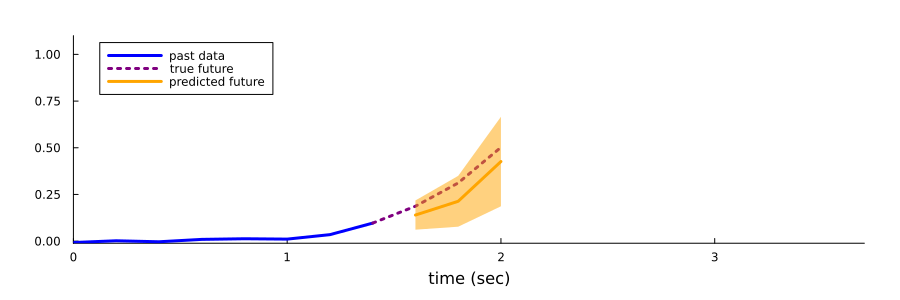

In [26]:
window = T+10
k = 8
plot(tsteps[1:k], y_EFE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
plot!(tsteps[k+1:k+T], mean.(py_EFE[k]), ribbon=var.(py_EFE[k]), label="predicted future", color="orange", legend=:topleft)

hline!([mean(goal)], color="green")

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-EFE-1Pendulum-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-EFE-1Pendulum-planning.gif")
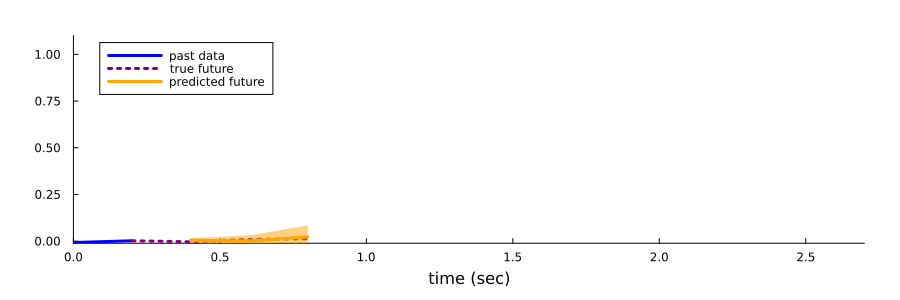

In [21]:
limsb = [minimum(y_EFE)*1.5, maximum(y_EFE)*1.5]

window = T+5

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_EFE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], mean.(py_EFE[k]), ribbon=var.(py_EFE[k]), label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    else
        plot(tsteps[k-window:k], y_EFE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], mean.(py_EFE[k]), ribbon=var.(py_EFE[k]), label="prediction", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    end
    
end
gif(anim, "figures/NARX-EFE-1Pendulum-planning.gif", fps=10)

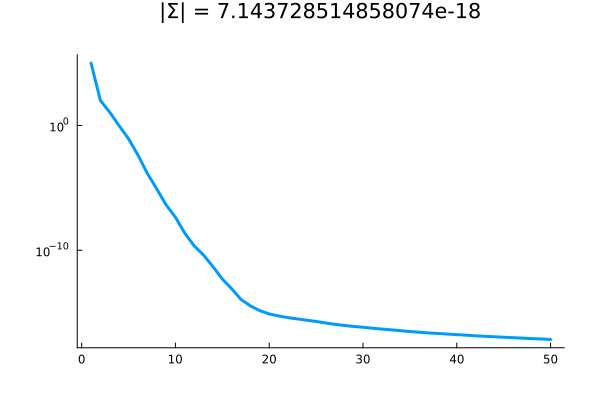

In [11]:
dSθ_EFE = [det(cov(pθ_EFE[k])) for k in 1:N]
final_dSθ_EFE = dSθ_EFE[end]
plot(dSθ_EFE, title="|Σ| = $final_dSθ_EFE", yscale=:log10)

### Mean Squared Error minimization

In [13]:
# Start system
pendulum = SPendulum(init_state = init_state, 
                     torque_lims = u_lims,
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     Δt=Δt)

# Track beliefs
py_MSE = [] 
pτ_MSE = [pτ0]
pθ_MSE = [pθ0]

# Start agent
agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  memory_actions=Lu, 
                  memory_senses=Ly, 
                  pol_degree=H,
                  thorizon=T,
                  control_prior=control_prior,
                  num_iters=num_iters)

# Preallocate
y_MSE = zeros(N)
u_MSE = zeros(N+1)
FE_MSE = zeros(num_iters, N)
policy = zeros(T)

@showprogress for k in 1:N
    
    # Act upon environment
    step!(pendulum, u_MSE[k])
    y_MSE[k] = pendulum.sensor
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_MSE[k], u_MSE[k])
    
    FE_MSE[:,k] = agent.free_energy
    push!(pθ_MSE, agent.qθ)
    push!(pτ_MSE, agent.qτ)
    
    # Optimal control
    policy = minimizeMSE(agent, time_limit=tlimit, control_lims=u_lims)
    u_MSE[k+1] = policy[1]
    
    # Store future predictions
    push!(py_MSE, predictions(agent, policy, time_horizon=T))
    
end

Progress:   4%|█▋                                       |  ETA: 0:00:44

Progress:  18%|███████▍                                 |  ETA: 0:00:10

Progress:  24%|█████████▉                               |  ETA: 0:00:07

Progress:  30%|████████████▎                            |  ETA: 0:00:06

Progress:  36%|██████████████▊                          |  ETA: 0:00:05

Progress:  42%|█████████████████▎                       |  ETA: 0:00:04

Progress:  48%|███████████████████▋                     |  ETA: 0:00:03

Progress:  54%|██████████████████████▏                  |  ETA: 0:00:02

Progress:  60%|████████████████████████▋                |  ETA: 0:00:02

Progress:  66%|███████████████████████████              |  ETA: 0:00:02

Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:01

Progress:  78%|████████████████████████████████         |  ETA: 0:00:01

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:01

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


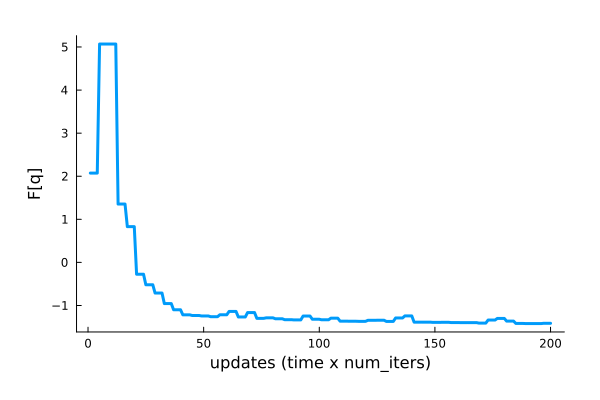

In [14]:
plot(FE_MSE[:], xlabel="updates (time x num_iters)", ylabel="F[q]")

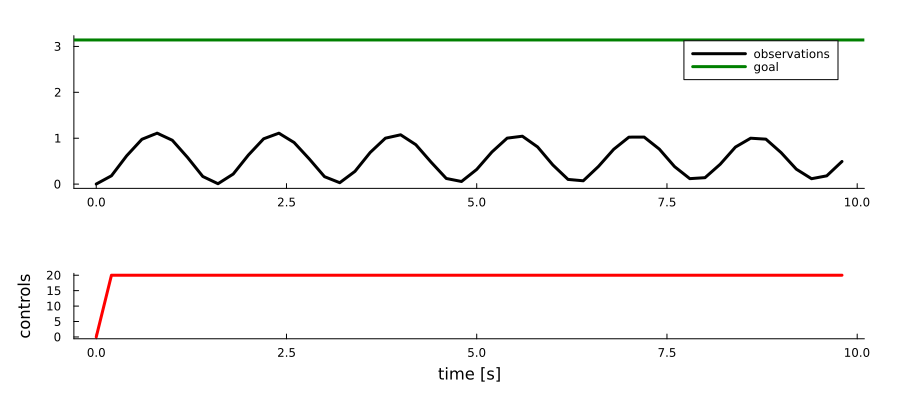

In [16]:
p1 = plot(tsteps, y_MSE, color="black", label="observations")
hline!([mean(goal)], color="green", label="goal")
p4 = plot(tsteps, u_MSE[1:end-1], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [17]:
savefig("figures/NARX-MSE-1Pendulum-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-MSE-1Pendulum-trial.png"

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-MSE-1Pendulum-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-MSE-1Pendulum-planning.gif")
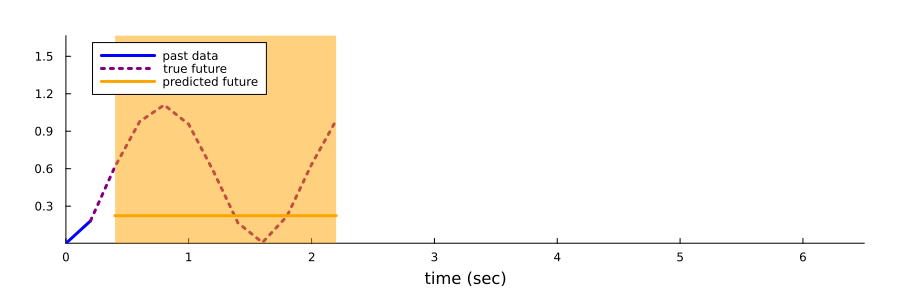

In [19]:
limsb = [minimum(y_MSE)*1.5, maximum(y_MSE)*1.5]

window = 20

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_MSE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], mean.(py_MSE[k]), ribbon=var.(py_MSE[k]), label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    else
        plot(tsteps[k-window:k], y_MSE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], mean.(py_MSE[k]), ribbon=var.(py_MSE[k]), label="prediction", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    end
    
end
gif(anim, "figures/NARX-MSE-1Pendulum-planning.gif", fps=10)

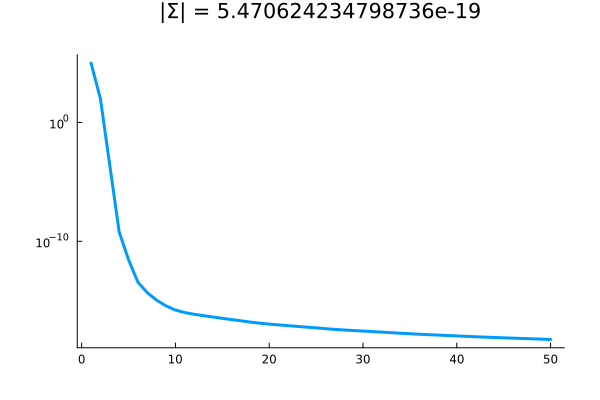

In [18]:
dSθ_MSE = [det(cov(pθ_MSE[k])) for k in 1:N]
final_dSθ_MSE = dSθ_MSE[end]
plot(dSθ_MSE, title="|Σ| = $final_dSθ_MSE", yscale=:log10)

### Comparisons

In [20]:
println("Final |Σ| MSE = $final_dSθ_MSE")
println("Final |Σ| EFE = $final_dSθ_EFE")

Final |Σ| MSE = 5.470624234798736e-19
Final |Σ| EFE = 7.143728514858074e-18


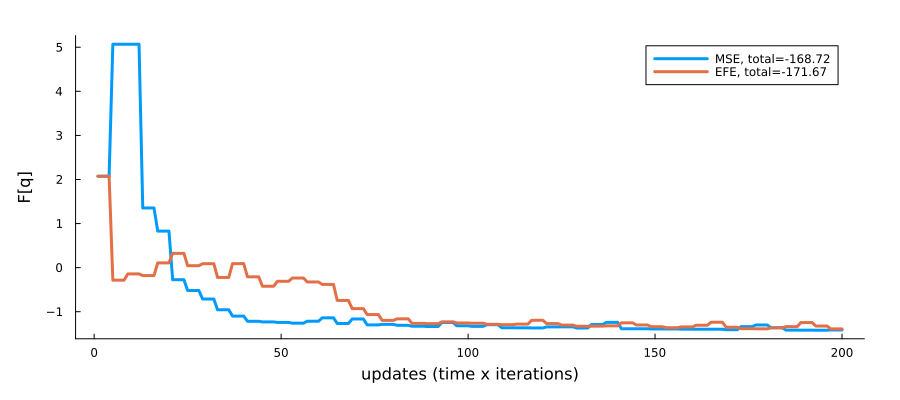

In [21]:
sF_MSE = round(sum(FE_MSE[:]), digits=2)
sF_EFE = round(sum(FE_EFE[:]), digits=2)

plot(xlabel="updates (time x iterations)", ylabel="F[q]", size=(900,400))
plot!(FE_MSE[:], label="MSE, total=$sF_MSE")
plot!(FE_EFE[:], label="EFE, total=$sF_EFE")

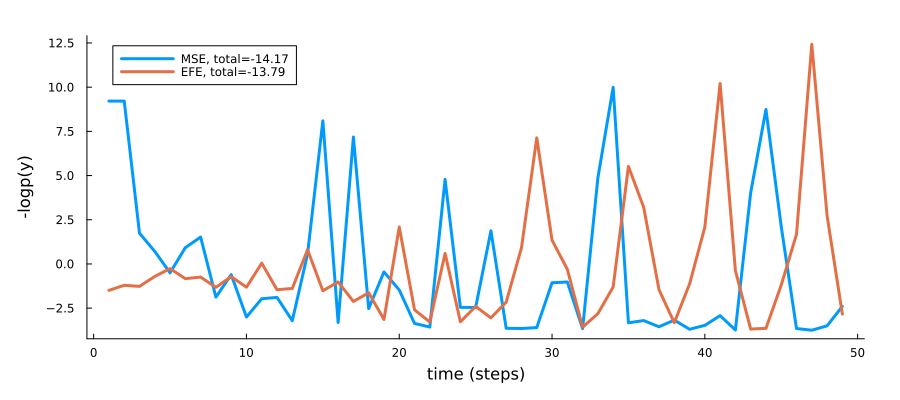

In [22]:
evidence_MSE = [-logpdf(py_MSE[k][1], y_MSE[k+1]) for k in 1:(N-1)]
evidence_EFE = [-logpdf(py_EFE[k][1], y_EFE[k+1]) for k in 1:(N-1)]

total_evidence_MSE = round(sum(evidence_MSE), digits=2)
total_evidence_EFE = round(sum(evidence_EFE), digits=2)

plot(xlabel="time (steps)", ylabel="-logp(y)", size=(900,400))
plot!(evidence_MSE, label="MSE, total=$total_evidence_MSE")
plot!(evidence_EFE, label="EFE, total=$total_evidence_EFE")

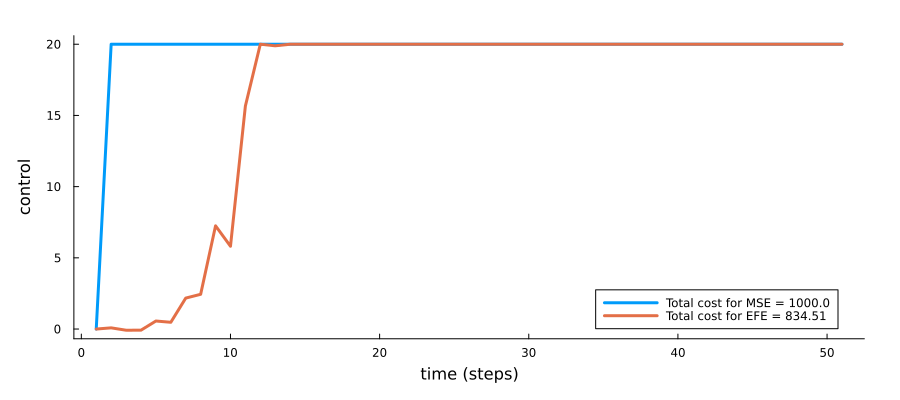

In [23]:
CC_MSE = round(sum(abs.(u_MSE)), digits=2)
CC_EFE = round(sum(abs.(u_EFE)), digits=2)

plot(xlabel="time (steps)", ylabel="control", size=(900,400))
plot!(u_MSE, label="Total cost for MSE = $CC_MSE")
plot!(u_EFE, label="Total cost for EFE = $CC_EFE")

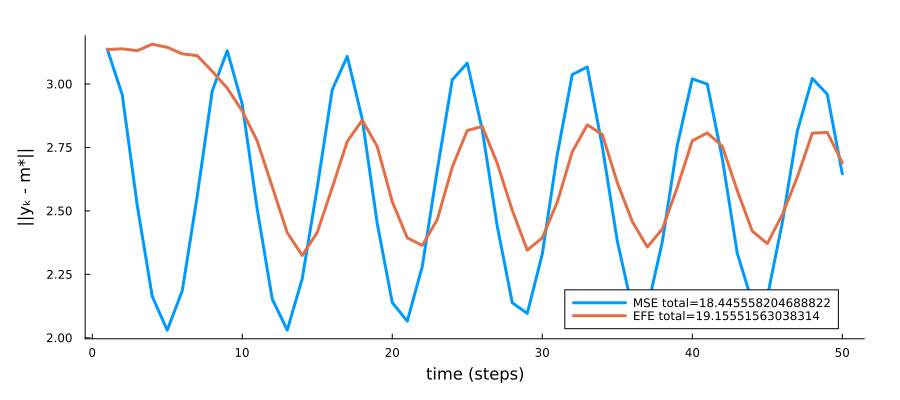

In [24]:
J_MSE = [norm(y_MSE[k] - mean(goal),2) for k in 1:N]
J_EFE = [norm(y_EFE[k] - mean(goal),2) for k in 1:N]

sJ_MSE = norm(y_MSE .- mean(goal),2)
sJ_EFE = norm(y_EFE .- mean(goal),2)

plot(xlabel="time (steps)", ylabel="||yₖ - m*||", size=(900,400))
plot!(J_MSE, label="MSE total=$sJ_MSE")
plot!(J_EFE, label="EFE total=$sJ_EFE")